## Scenerio

Let's imagine there's a bank that wants to segment their customers into clusters based on repayment potential.  Kind of like a credit score, but not manually calculated.

Using data from the [Lending Club](https://www.lendingclub.com/), a US peer-to-peer lending company.  Borrowers on the platform can borrow between `$`1000 to `$`40,000 in the form of unsecured personal loans, for a term of either three or five years.

Investors can browse the loan applications and choose to finance the loans based on the credit history of the borrower, the amount of the loan, the loan grade, and the purpose of the loan.  Investors earn money through interested paid on the loans, and Lending Club makes money from loan origination fees and service charges.

We will be using is from 2019 and is publicly available on the [Lending Club Website](https://www.lendingclub.com/statistics/additional-statistics?) (must make an account).  A data dictionary is also available.

# Imports

---

In [1]:
# Importing Libraries
'''Main'''
import numpy as np
import pandas as pd
import glob, os, re, time, decimal

'''Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.express as px
import plotly.graph_objs as go
import plotly as py

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as pp

'''Clustering Models'''
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist
import hdbscan

'''Multiprocessing'''
from multiprocessing.dummy import Pool
import functools

'''Model Evaluation'''
from sklearn.metrics import adjusted_rand_score, silhouette_score

'''Dimensionality Reduction Algorithms'''
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP


# Data

---

## Data Import

In [2]:
files = glob.glob(os.path.join('data', '*.zip'))
data = pd.concat((pd.read_csv(file, compression='zip', header=1, low_memory=False) for file in files), ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518115 entries, 0 to 518114
Columns: 150 entries, id to settlement_term
dtypes: float64(112), object(38)
memory usage: 592.9+ MB


In [3]:
data.shape

(518115, 150)

## Column Filtering

In [4]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

I don't really need all these columns, so we'll narrow them down.

In [5]:
print('old shape: ', data.shape)
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]
print('new shape: ', data.shape)

old shape:  (518115, 150)
new shape:  (518115, 37)


- **loan_amnt** : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- **funded_amnt** : The total amount committed to that loan at that point in time.
- **funded_amnt_inv** : The total amount committed by investors for that loan at that point in time.
- **term** : The number of payments on the loan. Values are in months and can be either 36 or 60.
- **int_rate** : Interest Rate on the loan
- **installment** : The monthly payment owed by the borrower if the loan originates.
- **grade** : LC assigned loan grade
- **sub_grade** : LC assigned loan subgrade
- **emp_length** : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_owndership** : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER. 
- **annual_inc** : The self-reported annual income provided by the borrower during registration.
- **verification_status** : The status of the loan during the listing period. Values: APPROVED, NOT_APPROVED.
- **pymnt_plan** : Indicates if a payment plan has been put in place for the loan
- **purpose** : A category provided by the borrower for the loan request. 
- **addr_state** : The state provided by the borrower in the loan application
- **dti** : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **delinq_2yrs** : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **earliest_cr_line** : The date the borrower's earliest reported credit line was opened
- **mths_since_last_delinq** : The number of months since the borrower's last delinquency.
- **mths_since_last_record** : The number of months since the last public record.
- **open_acc** : The number of open credit lines in the borrower's credit file.
- **pub_rec** : Number of derogatory public records
- **revol_bal** : Total credit revolving balance
- **revol_util** : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- **total_acc** : The total number of credit lines currently in the borrower's credit file
- **initial_list_status** : The initial listing status of the loan. Possible values are – W, F
- **out_prncp** : Remaining outstanding principal for total amount funded
- **out_prncp_inv** : Remaining outstanding principal for portion of total amount funded by investors
- **total_pymnt** : Payments received to date for total amount funded
- **total_pymnt_inv** : Payments received to date for portion of total amount funded by investors
- **total_rec_prncp** : Principal received to date
- **total_rec_int** : Interest received to date
- **total_rec_late_fee** : Late fees received to date
- **recoveries** : post charge off gross recovery
- **collection_recovery_fee** : post charge off collection fee
- **last_pymnt_d** : Last month payment was received
- **last_pymnt_amnt** : Last total payment amount received

In [6]:
data.head()

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment  \
0     5000.0       5000.0           5000.0   36 months   13.90%       170.65   
1     6500.0       6500.0           6475.0   36 months    8.81%       206.13   
2    24000.0      24000.0          24000.0   60 months   13.90%       557.20   
3    18500.0      18500.0          18500.0   60 months   14.74%       437.60   
4    24000.0      24000.0          24000.0   60 months   20.00%       635.86   

  grade sub_grade emp_length home_ownership  ...  out_prncp_inv total_pymnt  \
0     C        C1        NaN            OWN  ...        3164.76     2552.03   
1     A        A5  10+ years            OWN  ...           0.00     7015.28   
2     C        C1  10+ years       MORTGAGE  ...       20427.69     7206.53   
3     C        C2        NaN       MORTGAGE  ...       15121.23     6533.70   
4     D        D2    8 years       MORTGAGE  ...       20017.99     9484.57   

  total_pymnt_inv total_rec_prncp total_rec_int  total_rec_late_fee  \
0         2552.03         1835.24        716.79                 0.0   
1         6988.30         6500.00        515.28                 0.0   
2         7206.53         3572.31       3634.22                 0.0   
3         6533.70         3378.77       3154.93                 0.0   
4         9484.57         3982.01       5502.56                 0.0   

   recoveries collection_recovery_fee  last_pymnt_d  last_pymnt_amnt  
0         0.0                     0.0      Jun-2020           170.65  
1         0.0                     0.0      Apr-2020          4754.21  
2         0.0                     0.0      Jun-2020           557.20  
3         0.0                     0.0      Jul-2020           437.60  
4         0.0                     0.0      Jun-2020           635.86  

[5 rows x 37 columns]

## D-type and Nulls Cleaning

In [7]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                       8
funded_amnt                     8
funded_amnt_inv                 8
term                            8
int_rate                        8
installment                     8
emp_length                  46259
annual_inc                      8
dti                          1153
delinq_2yrs                     8
mths_since_last_delinq     292561
mths_since_last_record     462994
open_acc                        8
pub_rec                         8
revol_bal                       8
revol_util                    682
total_acc                       8
out_prncp                       8
out_prncp_inv                   8
total_pymnt                     8
total_pymnt_inv                 8
total_rec_prncp                 8
total_rec_int                   8
total_rec_late_fee              8
recoveries                      8
collection_recovery_fee         8
last_pymnt_amnt                 8
dtype: int64

In [8]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

## Feature Engineering and More Cleaning

In [9]:
# Feature engineering
# Typically ratios between loan amount, revolving balance, payments, 
# and the borrower's annual income
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

For some reason, issues were happening later on.  Found out some newly created columns were becoming 'null' aka positive infinity.

In [10]:
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: ', np.any(np.isnan(data.loc[:,newFeats])))

data.loc[:,newFeats].max()

NaN in numericalFeats:  False
NaN in newFeats:  True


installmentOverLoanAmnt    0.04295
loanAmntOverIncome             inf
revol_balOverIncome            inf
totalPymntOverIncome           inf
totalPymntInvOverIncome        inf
totalRecPrncpOverIncome        inf
totalRecIncOverIncome          inf
dtype: float64

In [11]:
print('old data shape: ', data.shape)
with pd.option_context('mode.use_inf_as_na', True):
    # Dropping the rows with nan  
    # (or inf) values 
    data.dropna(inplace=True)
    
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: ', np.any(np.isnan(data.loc[:,newFeats])))

print('new data shape: ', data.shape)

old data shape:  (518115, 44)
NaN in numericalFeats:  False
NaN in newFeats:  False
new data shape:  (516108, 44)


# Feature Selection and Scaling

---

## Features

In [12]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [13]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

## Labels

In [14]:
data.grade.value_counts(dropna=False)

A    165175
B    150906
C    121873
D     74726
E      3375
F        36
G        17
Name: grade, dtype: int64

I see the grades are imbalanced, but as this is unsupervised project, I have to assume we can't know.

In [15]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['C', 'A', 'D', 'B', 'E', 'G', 'F'], dtype=object)

In [16]:
# Fill missing labels if there are any
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name='grade')

# Store as y_train
y_train = labels

In [17]:
# View the changes
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew.head(5)

grade grade
0   2.0     C
1   0.0     A
2   2.0     C
3   2.0     C
4   3.0     D

In [18]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

int_rate
grade             
0.0    1285.583177
1.0    1286.537482
2.0    1288.398079
3.0    1290.670952
4.0    1243.752083
5.0    1351.028571
6.0    1209.294118

Now that we have X_train with all 34 numberical features and y_train with numerical loan grades (used only to validate the results).

Presumably, borrowers that are similar to each other and grouped together should have similar credit profiles.  Aka, their creditworthiness should be similar.

## Feature Correlation

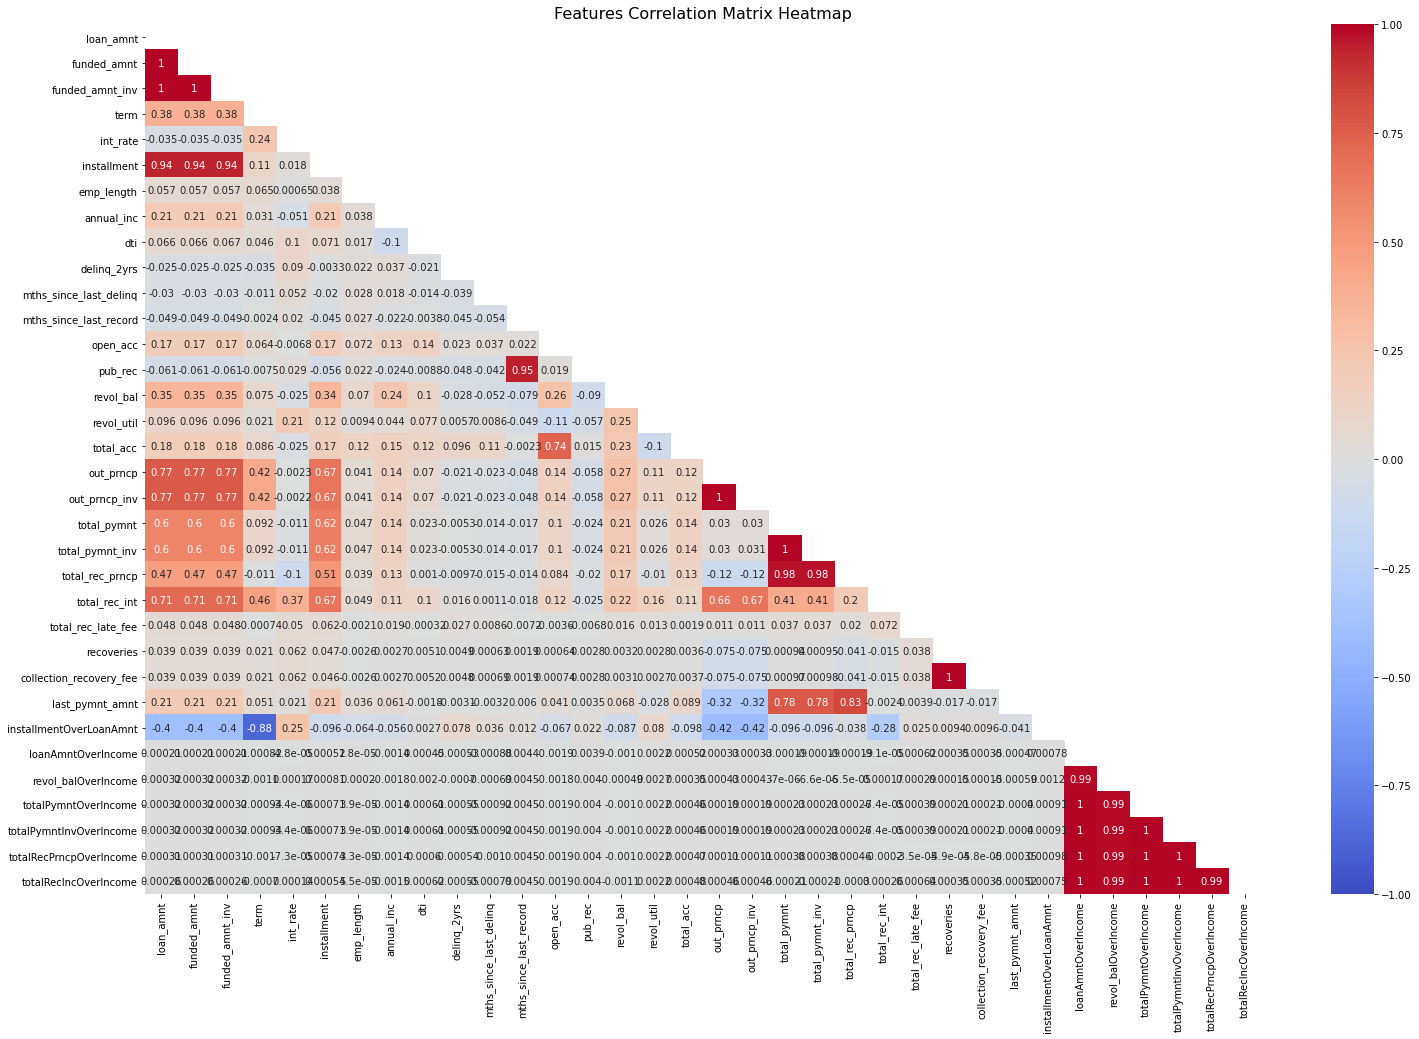

In [19]:
mask = np.triu(X_train[list(X_train.columns)].corr())
plt.figure(figsize=(25,16))
sns.heatmap(X_train[list(X_train.columns)].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
# plt.ylim(18, 0)
plt.title('Features Correlation Matrix Heatmap', size=16)
plt.show()

### Observation

We can see many features are correlated linearly, such as:
- loan_amnt, funded_amnt, funded_amnt_inv, installment.
- pub_rec, mths_since_last_record
- out_prncp_inv, out_prncp
- total_rec_prncp, total_pymnt, total_pymnt_inv
- recoveries, collection_recovery-fee
- loanAmntOverIncome, revol_balOverIncome, totalPymntOverIncome, totalPymntInvOverIncome, totalRecPrncpOverIncome, totalRecIncOverIncome
- installmentOverLoanAmnt, term

I'll try removing these and see if we can get a streamlined set of features.

In [20]:
X_train = X_train.drop(['funded_amnt', 'funded_amnt_inv', 'installment'], axis=1) # loan_amnt
X_train = X_train.drop(['mths_since_last_record'], axis=1) # pub_rec
X_train = X_train.drop(['out_prncp_inv'], axis=1) # out_prncp
X_train = X_train.drop(['total_pymnt', 'total_pymnt_inv'], axis=1) # total_rec_prncp
X_train = X_train.drop(['collection_recovery_fee'], axis=1) # recoveries
X_train = X_train.drop(['revol_balOverIncome', 'totalPymntOverIncome', 'totalPymntInvOverIncome', 'totalRecPrncpOverIncome', 'totalRecIncOverIncome'], axis=1) # loanAmntOverIncome
X_train = X_train.drop(['installmentOverLoanAmnt'], axis=1) # term

### New Feature Correlation

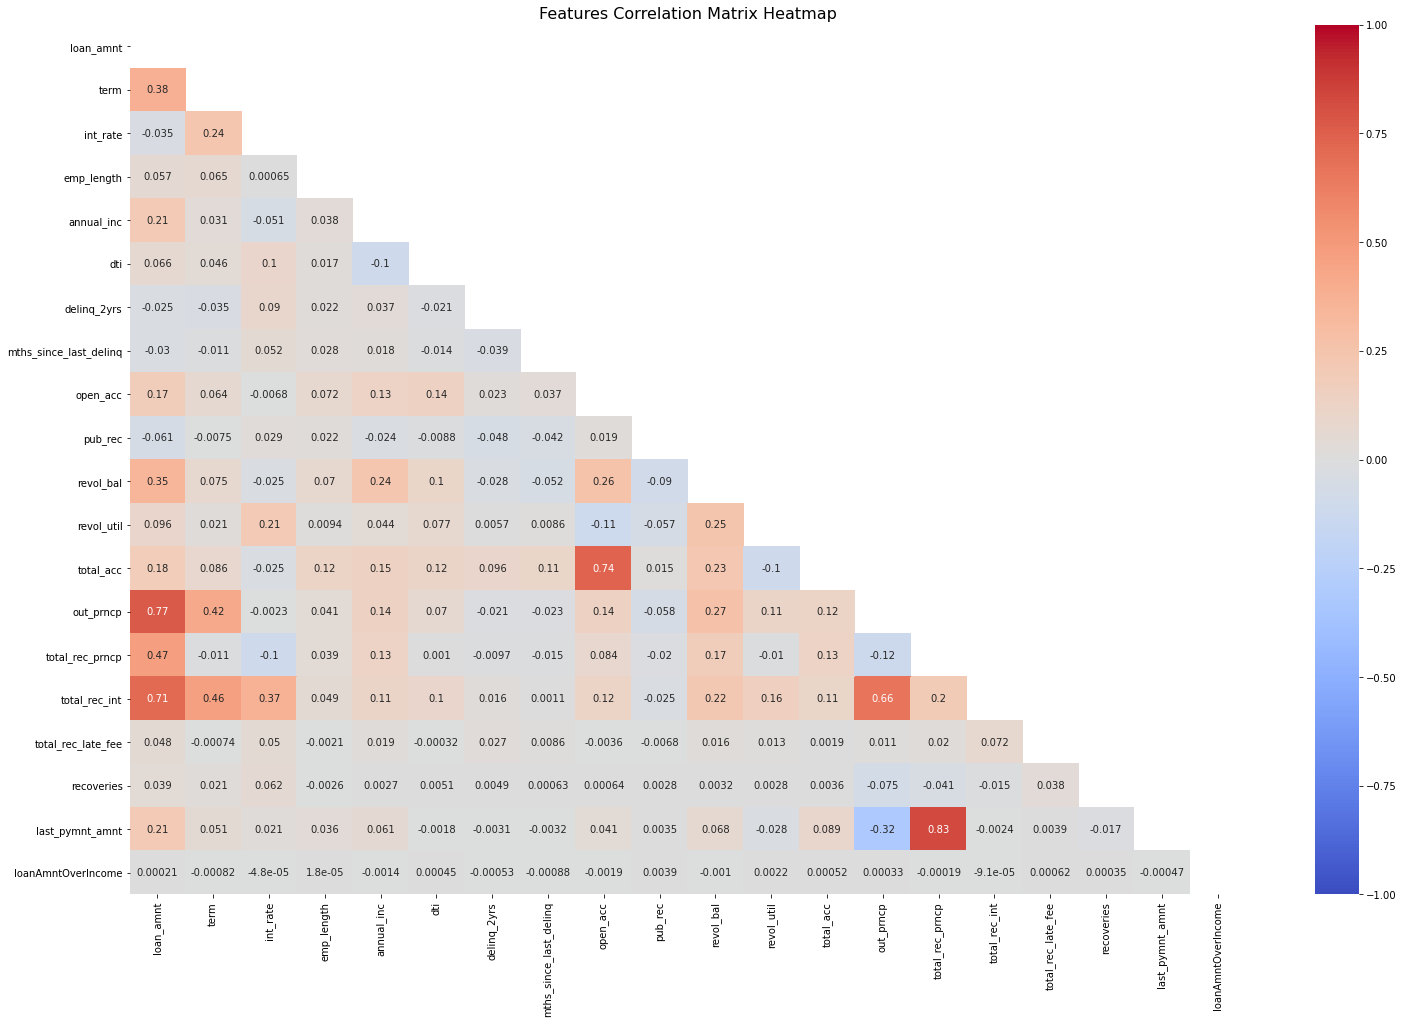

In [21]:
mask = np.triu(X_train[list(X_train.columns)].corr())
plt.figure(figsize=(25,16))
sns.heatmap(X_train[list(X_train.columns)].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
# plt.ylim(18, 0)
plt.title('Features Correlation Matrix Heatmap', size=16)
plt.show()

## PCA Features

In [22]:
pca_ = PCA().fit(X_train)
X_pca = PCA().fit_transform(X_train)

In [23]:
pca_evr = pca_.explained_variance_ratio_
cumsum_ = np.cumsum(pca_evr)

# Get dimensions where var >= 95%
dim_95 = np.argmax(cumsum_ >= 0.95) + 1
instances_, dims_ = X_train.shape

# check shape of X
if dims_ > instances_:
    print("WARNING: number of features greater than number of instances.")
    dimensions = list(range(1, instances_+1))
else:
    dimensions = list(range(1, dims_+1))
    
# Print report
print(f"You can reduce from {dims_} to {dim_95} dimensions while retaining 95% of variance.")

You can reduce from 20 to 16 dimensions while retaining 95% of variance.


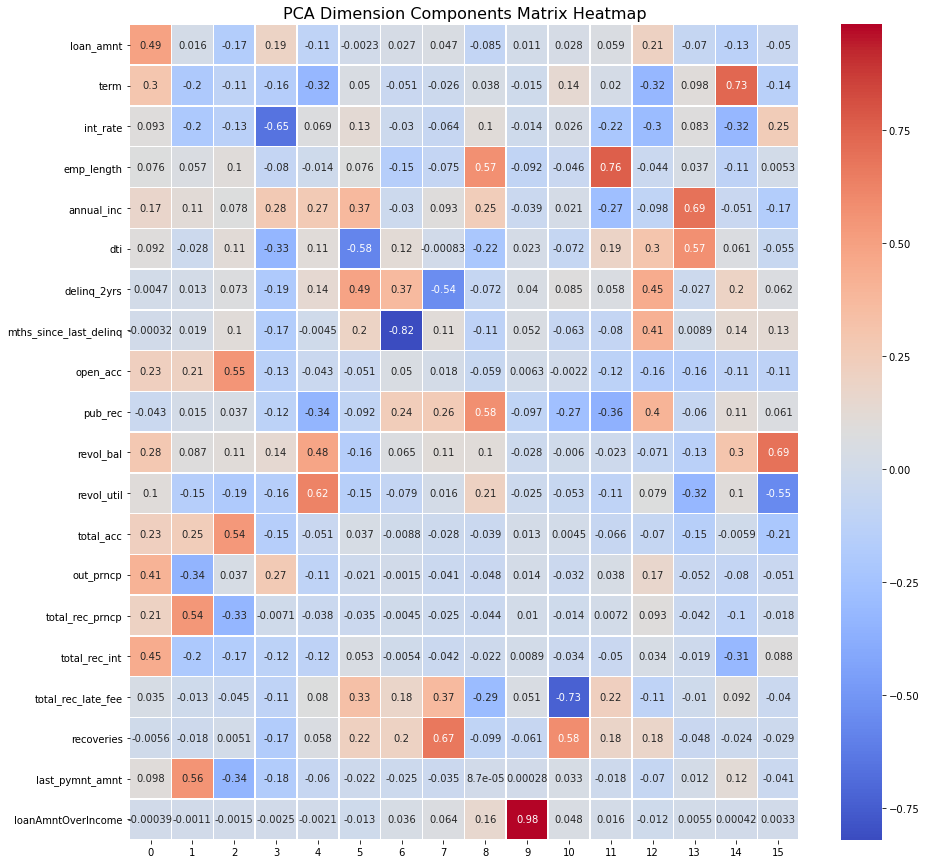

In [24]:
pca_16 = PCA(n_components=16).fit(X_train)
X_pca_16 = PCA(n_components=16).fit_transform(X_train)

PCAdf = pd.DataFrame(pca_16.components_, columns=list(X_train.columns))

# Load the example flights dataset and convert to long-form
feat_cor = PCAdf.T

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(feat_cor, annot=True, linewidths=.5, ax=ax, cmap='coolwarm')
plt.title('PCA Dimension Components Matrix Heatmap', size=16)
plt.show()

In [25]:
feat_cor.apply(lambda x: print(x.sort_values(ascending=False).head(5)), axis=0)

loan_amnt        0.491383
total_rec_int    0.447772
out_prncp        0.412221
term             0.296014
revol_bal        0.284829
Name: 0, dtype: float64
last_pymnt_amnt    0.560076
total_rec_prncp    0.542091
total_acc          0.246680
open_acc           0.213005
annual_inc         0.114309
Name: 1, dtype: float64
open_acc                  0.551213
total_acc                 0.538018
dti                       0.113655
revol_bal                 0.108285
mths_since_last_delinq    0.103607
Name: 2, dtype: float64
annual_inc            0.276965
out_prncp             0.267413
loan_amnt             0.194992
revol_bal             0.140314
loanAmntOverIncome   -0.002490
Name: 3, dtype: float64
revol_util     0.624533
revol_bal      0.477545
annual_inc     0.268811
delinq_2yrs    0.141519
dti            0.109721
Name: 4, dtype: float64
delinq_2yrs               0.488972
annual_inc                0.374840
total_rec_late_fee        0.334446
recoveries                0.219888
mths_since_last_deli

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
dtype: object

By running PCA, the cumsum shows that we can retain 95% of the variance with only 15 dimensions rather than 21.  So by running PCA again with only 16 dimensions and checking on the components of each dimension, we can see what features are connected.  Here's what we can see:

#### Dim0
- loan_amnt 0.49
- total_rec_int 0.44
- out_prncp 0.41

#### Dim1
- last_pymnt_amnt 0.56
- total_rec_prncp 0.54

#### Dim2
- open_acc 0.55
- total_acc 0.53

#### Dim3
- annual_inc 0.27
- out_prncp 0.27

#### Dim4
- revol_util 0.62
- revol_bal 0.47

#### Dim5
- delinq_2yrs 0.49
- annual_inc 0.37
- total_rec_late_fee 0.33

#### Dim6
- delinq_2yrs 0.37
- pub_rec 0.24
- recoveries 0.20

#### Dim7
- recoveries 0.67
- total_rec_late_fee 0.37
- pub_rec 0.26

#### Dim8
- pub_rec 0.58
- emp_length 0.57

#### Dim9
- loanAmntOverIncome 0.98

#### Dim10
- recoveries 0.58

#### Dim11
- emp_length 0.76

#### Dim12
- delinq_2yrs
- mths_since_last_delinq
- pub_rec

#### Dim13
- annual_inc 0.69
- dti 0.57

#### Dim14
- term 0.73
- revol_bal 0.30

#### Dim15
- revol_bal 0.69
- int_rate 0.25

When we run models, these will be the connections I will check out.

## Sampling 10,000

In [26]:
# Random sample of 10,000 out of ~510,000
np.random.seed(123)

indices = np.random.choice(data.shape[0],10000)
X = X_train.iloc[indices] / 255.0
y = y_train.iloc[indices]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(X.shape, y.shape)

(10000, 20) (10000,)


# Analyzing Clusters

---

The clusters we want should be filled with borrowers of similar numerical loan grade, which we will validate using the numerical loan grades we set aside in `y`.  The higher the percentage of borrowers that have the most frequently occuring numerical loan grade in each and every cluster, the better the clustering application.

For example, consider a cluster with 100 borrowers.  If 30 borrowers have the numerical grade of 0, 25 borrowers have a loan grade of 1, 20 borrowers have a loan grade of 2, and the remaining borrowers have loan grades ranging from 3 to 7, we would say that the cluster has a 30% accuracy, given that the most frequently occuring lonan grade for that cluster applies to just 30% of the borrowers in that cluster.

To analyze future clusters:

In [27]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x : x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on='cluster', right_on='cluster')
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

# Models

Let's run an experimet where K ranges from 10 to 30 and plot the results of the accuracy measure we defined.

## K-Means

<AxesSubplot:>

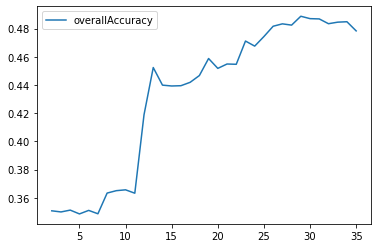

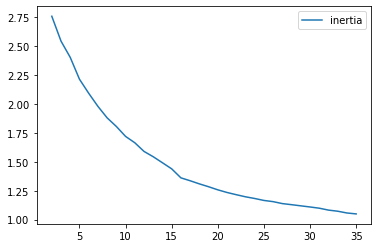

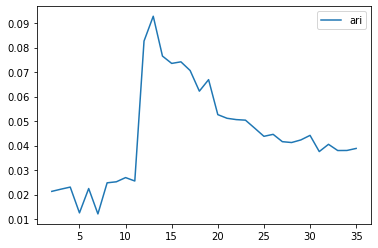

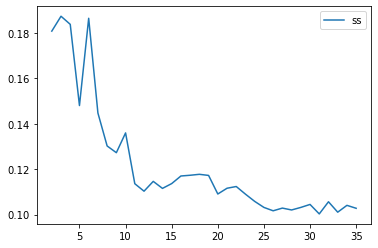

In [28]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 123
cluster_range = range(2,36)

kmeans = KMeans(n_clusters=n_clusters,
                n_init=n_init,
                max_iter=max_iter,
                tol=tol,
                random_state=random_state)
# Inertia
kMeans_inertia = pd.DataFrame(data=[],
                              index=cluster_range,
                              columns=['inertia'])
# Overall Accuracy
overallAccuracy_kMeansDF = pd.DataFrame(data=[],
                                        index=cluster_range,
                                        columns=['overallAccuracy'])
# ARI
ari_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ari'])
# Silhouette Score
ss_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ss'])
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)
    kmeans.fit(X)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    cluster = kmeans.predict(X)
    cluster_df = pd.DataFrame(data=cluster,
                         index=X.index,
                         columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(cluster_df, y)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans
    
    ari_KMeansDF.loc[n_clusters] = adjusted_rand_score(y, cluster)
    ss_KMeansDF.loc[n_clusters] = silhouette_score(X, cluster, metric='euclidean')
overallAccuracy_kMeansDF.plot()
kMeans_inertia.plot()
ari_KMeansDF.plot()
ss_KMeansDF.plot()

In [29]:
accuracyByLabel_kMeans

0     0.417886
1     0.356923
2     0.360938
3     0.750000
4     0.503448
5     0.404110
6     0.624506
7     0.718053
8     0.307692
9     0.333333
10    0.529412
11    0.401786
12    0.410072
13    1.000000
14    0.387097
15    0.527421
16    0.480000
17    0.500000
18    0.550000
19    0.342193
20    0.588477
21    0.478873
22    0.617357
23    0.505882
24    0.294821
25    0.273684
26    0.344262
27    0.664286
28    0.394737
29    0.368280
30    0.342342
31    0.380952
32    0.400000
33    0.399390
34    0.457082
dtype: float64

As we can see from overallAccuracy, the accuracy is best around 30 clusters and levels out there at aproximately 49% accuracy.

Inertia drops very gradually and consistently so there's never really an elbow to determine a clear number of clusters.

ARI shows a huge spike around 13-14 clusters.  Silhoette Score shows a drop around 7 then flattens out, although the difference is not as dramatic.

Let us try 13 clusters.

In [30]:
n_clusters = 13
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 123

kmeans = KMeans(n_clusters=n_clusters,
                n_init=n_init,
                max_iter=max_iter,
                tol=tol,
                random_state=random_state)

kmeans.fit(X)
kMeans_inertia.loc[n_clusters] = kmeans.inertia_
cluster = kmeans.predict(X)
cluster_df = pd.DataFrame(data=cluster,
                     index=X.index,
                     columns=['cluster'])

countByCluster_kMeans, countByLabel_kMeans, \
countMostFreq_kMeans, accuracyDF_kMeans, \
overallAccuracy_kMeans, accuracyByLabel_kMeans = \
analyzeCluster(cluster_df, y)

print('overallAccuracy_kMeans: ', overallAccuracy_kMeans)
print('ARI: ', adjusted_rand_score(y, cluster))
print('Silhouette Score: ', silhouette_score(X, cluster, metric='euclidean'))

overallAccuracy_kMeans:  0.4524
ARI:  0.09279624324041397
Silhouette Score:  0.11465279039276895


In [31]:
accuracyByLabel_kMeans

0     0.314159
1     0.400445
2     0.382230
3     0.386991
4     0.750000
5     0.526316
6     0.447368
7     0.617886
8     1.000000
9     0.371113
10    0.610671
11    0.400000
12    0.291498
dtype: float64

In [32]:
accuracyDF_kMeans

cluster  countMostFrequent  clusterCount
0         0                284           904
1         1                360           899
2         2                641          1677
3         3                589          1522
4         4                  3             4
5         5                 40            76
6         6                 17            38
7         7                608           984
8         8                  1             1
9         9                370           997
10       10               1465          2399
11       11                  2             5
12       12                144           494

We see why certain clusters were 100% accurate: they're cluster-size of 1.

Starting point to build a clustering application to automatically assign new borrowers that apply for a Lending Club loan into a pre-existing group based on how similar they are to the other borrowers.

## KMeans n_components=13

In [33]:
cluster = kmeans.predict(X)
cluster_df = pd.DataFrame(data=cluster,
                     index=X.index,
                     columns=['cluster'])

In [34]:
kmeans_df = X
kmeans_df['cluster'] = cluster

In [48]:
len(kmeans_df.columns)

21

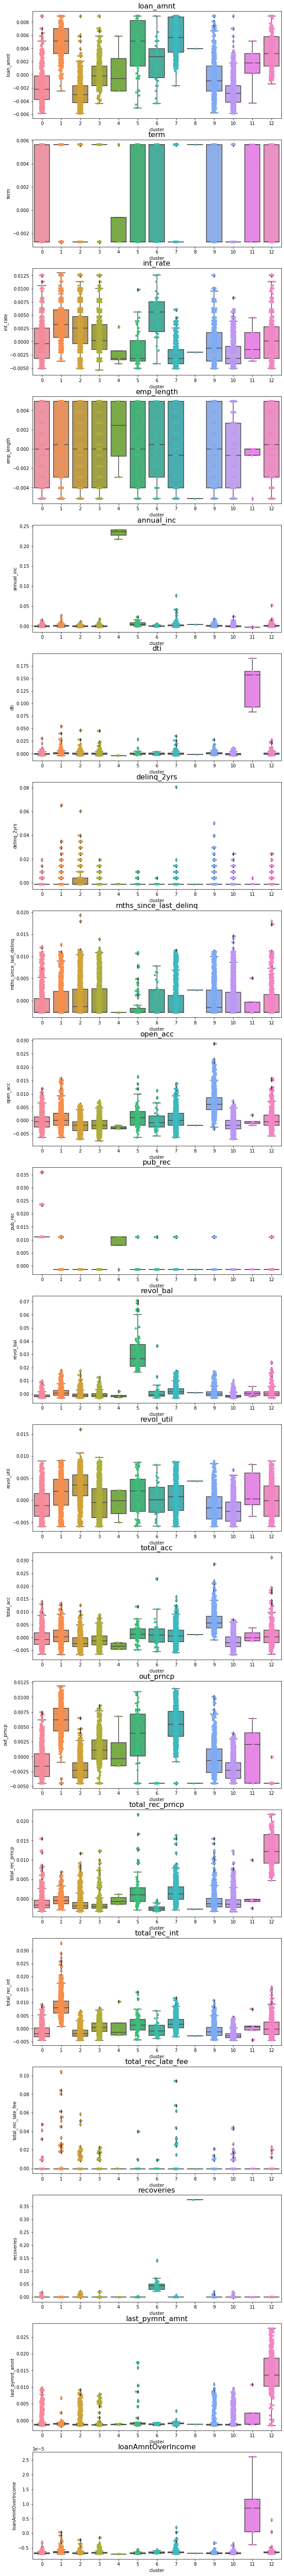

In [57]:
def plot_cluster(y, x='cluster', data=kmeans_df, ax=ax):
    sns.stripplot(data=data, x=x, y=y, ax=ax)
    sns.boxplot(data=data, x=x, y=y, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y);
    ax.set_title(y, size=16)
    
fig, axes = plt.subplots(20, 1, figsize=(10,105))
for i in range(len(axes)):
    plot_cluster(y=kmeans_df.columns[i], ax=axes[i])

### Dim0
**loan_amnt** : The listed amount of the loan applied for by the borrower. 
    If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

**total_rec_int** : Interest received to date

**out_prncp** : Remaining outstanding principal for total amount funded

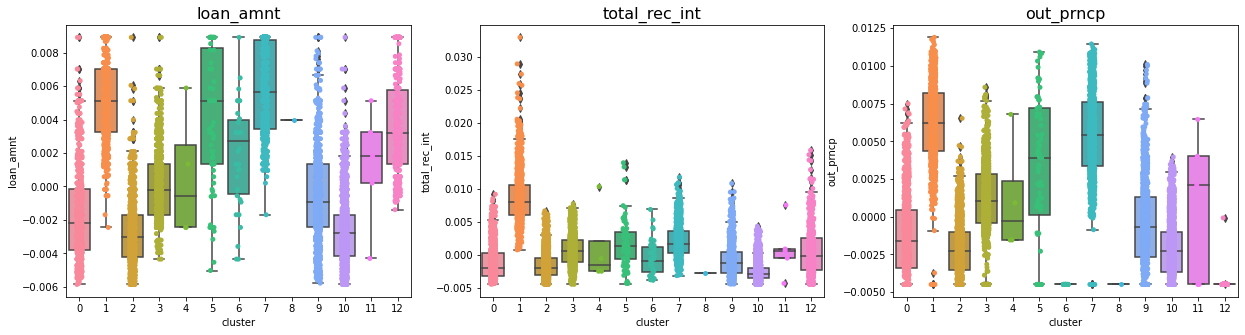

In [58]:
dim_cols = ['loan_amnt', 'total_rec_int', 'out_prncp']
    
fig, axes = plt.subplots(1, len(dim_cols), figsize=(len(dim_cols)*7,5))
for i in range(len(axes)):
    plot_cluster(y=dim_cols[i], ax=axes[i])

Current Observation:

Cluster 8 is not very important, as it's a cluster of 1.  Will ignore for the most part.

Cluster 1 generally has high loan amount, high interest payment, and high remaining principal, and high outstanding principal remaining.

Cluster 5 and 7 are like Cluster 1, without the high interest payment, meaning they at least pay their interests, but still have a lot of loan left to pay.

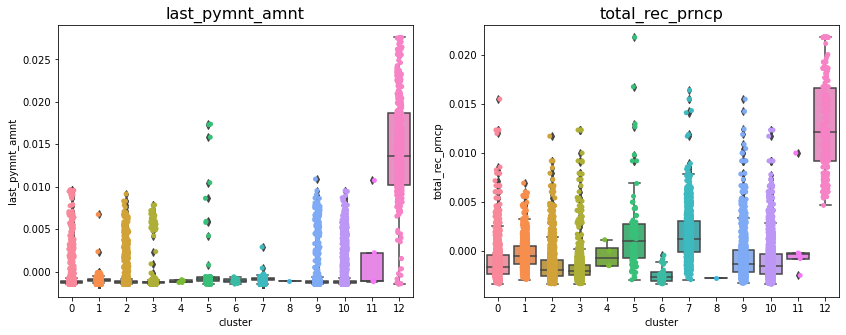

In [59]:
dim_cols = ['last_pymnt_amnt', 'total_rec_prncp']
    
fig, axes = plt.subplots(1, len(dim_cols), figsize=(len(dim_cols)*7,5))
for i in range(len(axes)):
    plot_cluster(y=dim_cols[i], ax=axes[i])

## Hierarchical Clustering

In [25]:
train_index = range(0, len(X))

# Principal Component Analysis

n = len(X.columns) #n_components
whiten = False
rs = 123 # random_state

pca = PCA(n_components=n, whiten=whiten, random_state=rs)

X_PCA = pca.fit_transform(X)
X_PCA_df = pd.DataFrame(data=X_PCA, index=train_index)

In [26]:
Z = fastcluster.linkage_vector(X, method='ward', metric='euclidean')
Z_df = pd.DataFrame(data=Z, columns=['clusterOne', 
                                    'clusterTwo', 
                                    'distance', 
                                    'newClusterSize'])

In [27]:
# distance_threshold = 0.175
# clusters = fcluster(Z, distance_threshold, criterion = 'distance')
# X_hierClustered = pd.DataFrame(data=clusters,
#                                index=X_PCA_df.index,
#                                columns=['cluster'])
# print("Number of distinct clusters: ", len(X_hierClustered['cluster'].unique()))

#---

dist_thresh_range = range(0.01, 0.31, 0.05)

# Overall Accuracy
overallAccuracy_hierClustDF = pd.DataFrame(data=[],
                                        index=dist_thresh_range,
                                        columns=['overallAccuracy'])
# ARI
ari_hierClustDF = pd.DataFrame(data=[],
                            index=dist_thresh_range,
                            columns=['ari'])
# Silhouette Score
ss_hierClustDF = pd.DataFrame(data=[],
                            index=dist_thresh_range,
                            columns=['ss'])
for dist_thresh in dist_thresh_range:
    clusters = fcluster(Z,
                    dist_thresh,
                    criterion = 'distance')
    X_hierClustered = pd.DataFrame(data=clusters, index=X_PCA_df.index, columns=['cluster'])
    print("Number of distinct clusters for {} distance threshold:  {}".format(dist_thresh, len(X_hierClustered['cluster'].unique())))
    cluster_df = pd.DataFrame(data=cluster,
                         index=X.index,
                         columns=['cluster'])
    
    countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, \
    accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_hierClustered, y)
    
    overallAccuracy_hierClustDF.loc[dist_thresh_range] = overallAccuracy_kMeans
    
    ari_hierClustDF.loc[dist_thresh_range] = adjusted_rand_score(y, cluster)
    ss_hierClustDF.loc[dist_thresh_range] = silhouette_score(X, cluster, metric='euclidean')
overallAccuracy_highClustDF.plot()
ari_hierClustDF.plot()
ss_hierClustDF.plot()

Number of distinct clusters:  32


In [28]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, \
accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = \
analyzeCluster(X_hierClustered, y)
print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.4416


In [29]:
print('ARI: ', adjusted_rand_score(y, clusters))
print('Silhouette Score: ', silhouette_score(X, clusters, metric='euclidean'))

ARI:  0.031174411715960332
Silhouette Score:  0.07110083374734891


In [30]:
accuracyByLabel_hierClust

0     0.368110
1     0.333333
2     0.316489
3     0.416667
4     0.578947
5     0.475806
6     0.346032
7     0.375000
8     0.479058
9     0.705600
10    0.377778
11    0.402778
12    0.632629
13    0.454121
14    0.400000
15    0.363636
16    0.333333
17    0.345882
18    0.348783
19    0.333333
20    0.464286
21    0.750000
22    0.269231
23    0.330779
24    0.555556
25    0.630058
26    0.576832
27    0.429224
28    0.383721
29    0.372881
30    0.265823
31    1.000000
dtype: float64

Again, we can see percentage ranges from 26% to 100%, with the 100% because it's a cluster-size of 1.

In [31]:
accuracyDF_hierClust

cluster  countMostFrequent  clusterCount
0         1                187           508
1         2                 30            90
2         3                119           376
3         4                 20            48
4         5                 11            19
5         6                118           248
6         7                109           315
7         8                 42           112
8         9                183           382
9        10                441           625
10       11                289           765
11       12                290           720
12       13                539           852
13       14                292           643
14       15                 10            25
15       16                104           286
16       17                  1             3
17       18                147           425
18       19                301           863
19       20                  6            18
20       21                208           448
21       22                  3             4
22       23                  7            26
23       24                259           783
24       25                 25            45
25       26                218           346
26       27                244           423
27       28                 94           219
28       29                 33            86
29       30                 22            59
30       31                 63           237
31       32                  1             1

Number of distinct clusters for 0.01 distance threshold:  3645
Number of distinct clusters for 0.03 distance threshold:  562
Number of distinct clusters for 0.05 distance threshold:  236
Number of distinct clusters for 0.07 distance threshold:  138
Number of distinct clusters for 0.09 distance threshold:  91
Number of distinct clusters for 0.11 distance threshold:  62
Number of distinct clusters for 0.13 distance threshold:  52
Number of distinct clusters for 0.15 distance threshold:  43
Number of distinct clusters for 0.17 distance threshold:  33
Number of distinct clusters for 0.19 distance threshold:  28
Number of distinct clusters for 0.21 distance threshold:  24
Number of distinct clusters for 0.23 distance threshold:  20
Number of distinct clusters for 0.25 distance threshold:  19
Number of distinct clusters for 0.27 distance threshold:  18
Number of distinct clusters for 0.29 distance threshold:  16


<AxesSubplot:>

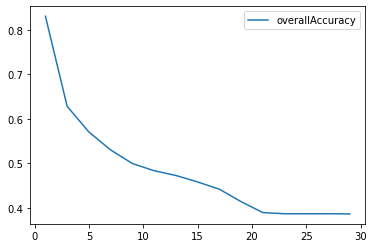

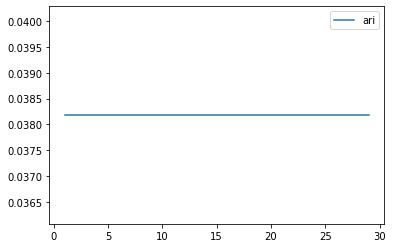

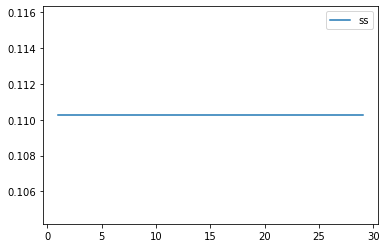

In [67]:
# distance_threshold = 0.175
# clusters = fcluster(Z, distance_threshold, criterion = 'distance')
# X_hierClustered = pd.DataFrame(data=clusters,
#                                index=X_PCA_df.index,
#                                columns=['cluster'])
# print("Number of distinct clusters: ", len(X_hierClustered['cluster'].unique()))

#---

dist_thresh_range = range(1, 31, 2)

# Overall Accuracy
overallAccuracy_hierClustDF = pd.DataFrame(data=[],
                                        index=dist_thresh_range,
                                        columns=['overallAccuracy'])
# ARI
ari_hierClustDF = pd.DataFrame(data=[],
                            index=dist_thresh_range,
                            columns=['ari'])
# Silhouette Score
ss_hierClustDF = pd.DataFrame(data=[],
                            index=dist_thresh_range,
                            columns=['ss'])
for dist_thresh in dist_thresh_range:
    clusters = fcluster(Z,
                    dist_thresh/100,
                    criterion = 'distance')
    X_hierClustered = pd.DataFrame(data=clusters, index=X_PCA_df.index, columns=['cluster'])
    print("Number of distinct clusters for {} distance threshold:  {}".format(dist_thresh/100, len(X_hierClustered['cluster'].unique())))
    cluster_df = pd.DataFrame(data=clusters,
                         index=X.index,
                         columns=['cluster'])
    
    countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, \
    accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = \
    analyzeCluster(X_hierClustered, y)
    
    overallAccuracy_hierClustDF.loc[dist_thresh] = overallAccuracy_hierClust
    
    ari_hierClustDF.loc[dist_thresh] = adjusted_rand_score(y, cluster)
    ss_hierClustDF.loc[dist_thresh] = silhouette_score(X, cluster, metric='euclidean')
overallAccuracy_hierClustDF.plot()
ari_hierClustDF.plot()
ss_hierClustDF.plot()

ARI and Silhouette Score doesn't change regardless of distance threshold.

Due to how python's `range` function works, I can only use range with ints, so to incorperate floats, those numbers were divided by 100.  So to read the charts above, the x-axis should be divided by 100.

Overall accuracy for 0.1 was super high, but that's most likely due to having 3645 clusters, meaning a lot of clusters only had one, meaning 100%.  At about `distance_threshold = 1.75`, there's ~32 clusters with `0.44` overall score.  The score plateus from `distance_threshold = 0.21` at just shy of `0.4`.

ARI score of 0.0382 and Silhouette Score of 0.111 is nothing to scoff at either.

##  HDBSCAN Application

In [32]:
min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method)

X_hdbscanClustered = hdb.fit_predict(X)
X_hdbscanClustered_df = pd.DataFrame(data=X_hdbscanClustered,
                                     index=X.index,
                                     columns=['cluster'])
countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
analyzeCluster(X_hdbscanClustered_df, y)

print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)
print('ARI: ', adjusted_rand_score(y, X_hdbscanClustered))
print('Silhouette Score: ', silhouette_score(X, X_hdbscanClustered, metric='euclidean'))

Overall accuracy from hierarchical clustering:  0.4416
ARI:  0.05254816559276286
Silhouette Score:  0.08084351789502861


In [33]:
accuracyByLabel_hdbscan

0    0.256751
1    0.455224
2    0.449102
3    0.438173
4    0.393836
5    0.479167
dtype: float64

My increasing the minimum cluster-size, we can get similar results from only 6 clusters.

In [34]:
accuracyDF_hdbscan

cluster  countMostFrequent  clusterCount
0       -1                580          2259
1        0                 61           134
2        1                225           501
3        2               2197          5014
4        3                805          2044
5        4                 23            48

From the cluster dataframe, we can see almost a quarter of the data was not grouped at all.  ARI and Silhouette Scores are a smidgen higher compared to previous methods.  Pretty sure results can be improved.

In [ ]:
hbd_max = hbdscan.HDBSCAN(memory=)
parameters = {
    'min_cluster_size':[10, 20, 30, 60],
    'min_samples':[10, 15, 20, 30],
    'cluster_selection_method': ['eom','leaf']
}
cv = GridSearchCV(hbd_max, parameters, cv=5)
cv.fit(X, y)

In [78]:
hdb_max = hdbscan.HDBSCAN()

# define custom fucntion for passing into each thread
def find_cluster(hdb_scan=hdb_max, X=X, min_cluster_size=20, min_samples=15, cluster_selection_method='leaf'):
    from sklearn.metrics import silhouette_score as ss # I can to import scorerer in my function
    
    hdb_scan.set_params(min_cluster_size=min_cluster_size,
                        min_samples = min_samples,
                        cluster_selection_method = cluster_selection_method)
    hdb_max_results = hdb_max.fit_predict(X)  # Fit and Predict
    score = ss(X, hdb_results)  # Get the score

X_hdbscanClustered = hdb.fit_predict(X)
X_hdbscanClustered_df = pd.DataFrame(data=X_hdbscanClustered,
                                     index=X.index,
                                     columns=['cluster'])

countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
analyzeCluster(X_hdbscanClustered_df, y)

print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)
print('ARI: ', adjusted_rand_score(y, X_hdbscanClustered))
print('Silhouette Score: ', silhouette_score(X, X_hdbscanClustered, metric='euclidean'))

In [84]:
overallAcc_scores = []
ari_scores = []
sil_scores = []
min_clust_param = []
min_sample_param = []
clust_select_method_param = []
    
# Now's the parallel implementation
min_cluster_size_param = [10, 20, 30, 60]
min_samples_param = [10, 15, 20, 30]
cluster_selection_method_param = ['eom', 'leaf'] # 'eom'

for cluster_size in min_cluster_size_param:
    for samples in min_samples_param:
        for selection_method in cluster_selection_method_param:
            hdb_scan.set_params(min_cluster_size=cluster_size,
                                min_samples = samples,
                                cluster_selection_method = selection_method)
            hdb_scan_results = hdb_scan.fit_predict(X) # Fit and Predict
            hdb_scan_results_df = pd.DataFrame(data=hdb_scan_results,
                                               index=X.index, 
                                               columns=['cluster'])
            
            countByCluster_hdbscan, countByLabel_hdbscan, \
            countMostFreq_hdbscan, accuracyDF_hdbscan, \
            overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
            analyzeCluster(X_hdbscanClustered_df, y)
            
            overallAcc_scores.append(overallAccuracy_hierClust)
            ari_scores.append(adjusted_rand_score(y, hdb_scan_results))
            sil_scores.append(silhouette_score(X, hdb_scan_results))
            min_clust_param.append(cluster_size)
            min_sample_param.append(samples)
            clust_select_method_param.append(selection_method)

resultsDF = pd.DataFrame()
resultsDF['min_cluster_size'] = min_clust_param
resultsDF['min_samples'] = min_sample_param
resultsDF['cluster_selection_method'] = clust_select_method_param
resultsDF['overallAccuracy'] = overallAcc_scores
resultsDF['ARI'] = ari_scores
resultsDF['SS'] = sil_scores

print('Max ARI')
print(resultsDF[resultsDF.ARI == resultsDF.ARI.max()])
print('\n')
print('Max Silhouette Score')
print(resultsDF[resultsDF.SS == resultsDF.SS.max()])
print('\n')
print('Max overallAccuracy')
print(resultsDF[resultsDF.overallAccuracy == resultsDF.overallAccuracy.max()])
print('\n')

Max ARI
    min_cluster_size  min_samples cluster_selection_method  overallAccuracy  \
26                60           15                      eom            0.386   
27                60           15                     leaf            0.386   

         ARI        SS  
26  0.055098  0.117569  
27  0.055098  0.117569  


Max Silhouette Score
    min_cluster_size  min_samples cluster_selection_method  overallAccuracy  \
26                60           15                      eom            0.386   
27                60           15                     leaf            0.386   

         ARI        SS  
26  0.055098  0.117569  
27  0.055098  0.117569  


Max overallAccuracy
    min_cluster_size  min_samples cluster_selection_method  overallAccuracy  \
0                 10           10                      eom            0.386   
1                 10           10                     leaf            0.386   
2                 10           15                      eom            0.386   
3    

In [86]:
resultsDF.to_csv('HDBSCAN_results.csv', index=False)

In [32]:
min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method)

X_hdbscanClustered = hdb.fit_predict(X)
X_hdbscanClustered_df = pd.DataFrame(data=X_hdbscanClustered,
                                     index=X.index,
                                     columns=['cluster'])
countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
analyzeCluster(X_hdbscanClustered_df, y)

print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)
print('ARI: ', adjusted_rand_score(y, X_hdbscanClustered))
print('Silhouette Score: ', silhouette_score(X, X_hdbscanClustered, metric='euclidean'))

Overall accuracy from hierarchical clustering:  0.4416
ARI:  0.05254816559276286
Silhouette Score:  0.08084351789502861


# Visualizations

## 3D

### PCA

In [36]:
Xpca_3 = PCA(n_components=3, random_state=123).fit_transform(X)

In [40]:
Xpca_3[:,0]

array([-0.01440159,  0.00343625, -0.0057062 , ...,  0.01302073,
       -0.00272596, -0.0163509 ])

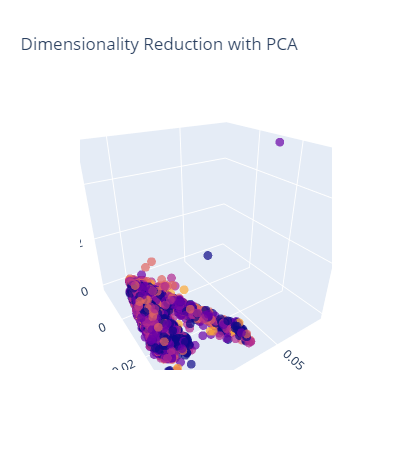

In [51]:
chart3d = go.Scatter3d(
    x = Xpca_3[:,0],# First Column
    y = Xpca_3[:,1],
    z = Xpca_3[:,2],
    mode='markers',
    marker=dict(
        color = y,
        size = 5,
        line=dict(color = y),
        opacity = 0.7
        )
    )
layout = go.Layout(
    title = 'Dimensionality Reduction with PCA',
    scene = dict(
        xaxis = dict(title = 'Dim 1'),
        yaxis = dict(title = 'Dim 2'),
        zaxis = dict(title = 'Dim 3')
        )
    )

# Show the chart
fig = go.Figure(data=chart3d, layout=layout)
py.offline.iplot(fig)

### TSNE

In [48]:
time_start = time.time()
Xtsne_3 = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, random_state=123).fit_transform(X)
print('t-SNE done!  Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.220s...
[t-SNE] Computed neighbors for 10000 samples in 6.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.003813
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.597061
[t-SNE] KL divergence after 300 iterations: 2.540874
t-SNE done!  Time elapsed

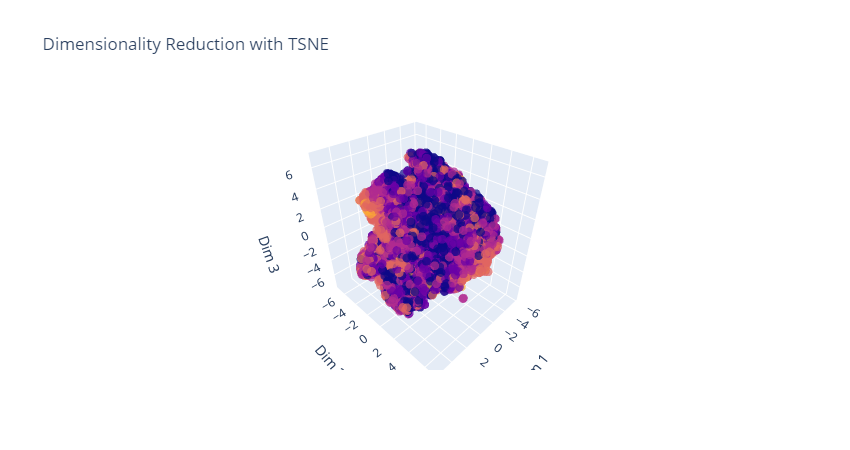

In [52]:
chart3d_tsne = go.Scatter3d(
    x = Xtsne_3[:,0],# First Column
    y = Xtsne_3[:,1],
    z = Xtsne_3[:,2],
    mode='markers',
    marker=dict(
        color = y,
        size = 5,
        line=dict(color = y),
        opacity = 0.7
        )
    )
layout = go.Layout(
    title = 'Dimensionality Reduction with TSNE',
    scene = dict(
        xaxis = dict(title = 'Dim 1'),
        yaxis = dict(title = 'Dim 2'),
        zaxis = dict(title = 'Dim 3')
        )
    )

# Show the chart
fig = go.Figure(data=chart3d_tsne, layout=layout)
py.offline.iplot(fig)

### UMAP

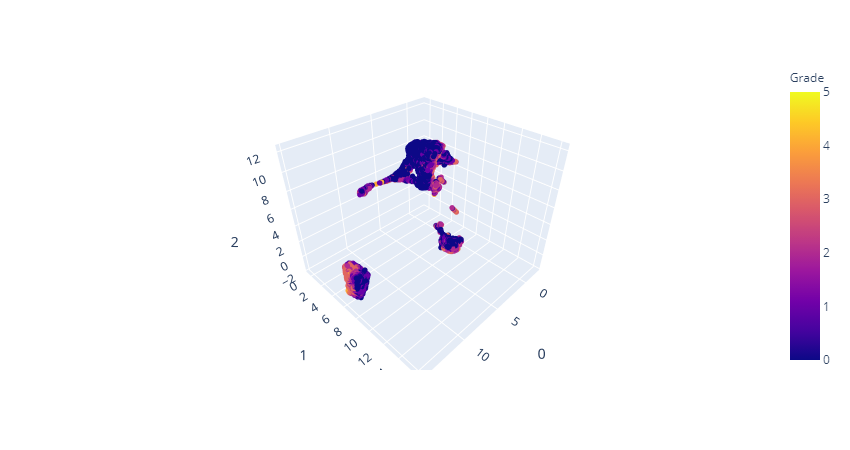

In [58]:
umap_3d = UMAP(n_components=3, init='random', random_state=123)

proj_3d = umap_3d.fit_transform(X)

fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=y, labels={'color': 'Grade'}
)
fig_3d.update_traces(marker_size=3)

fig_3d.show()

Based on the complexity of the data, an extra dimension goes a long way.  Out of all the visualizations, I prefer UMAP 3D as it does a better job of grouping datapoints, not necessairly by grade, but by actual clusters.

# Conclusion

#### Kmeans - 35 clusters
- Overall - 0.48
- ARI - 0.045
- SS - 0.11

#### Hierarchical - 32 clusters
- Overall - 0.44
- ARI - 0.03
- SS - 0.07

#### HDBSCAN - 5 clusters (1 non-cluster)
- Overall - 0.44
- ARI - 0.052
- SS - 0.08